# Processing your Eclipse Photo with SunPy

Requirements
* Python 3
* matplotlib
* scipy
* sunpy >= 0.8
* skimage
* exifread
* astropy

In [1]:
import copy
from datetime import datetime

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

import scipy.ndimage as ndimage
from skimage.transform import hough_circle, hough_circle_peaks

import astropy.wcs
from astropy.coordinates import EarthLocation, SkyCoord
import astropy.units as u

import sunpy
import sunpy.map
import sunpy.coordinates

import exifread # to read information from the image

from eclipse import SAMPLE_PHOTO

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
sunpy.system_info()

 SunPy Installation Information


###########
 General
###########
Time : Wednesday, 04. April 2018 09:19AM UT
System : Linux
Processor : 
Arch : 64bit
SunPy : 0.9.dev9305
SunPy_git : 608a6f0b55b1d9cb5a17efeaf58e2c62dd298ffe
OS: arch   (Linux 4.15.14-1-ARCH )


###########
 Required Libraries 
###########
Python: 3.6.4
NumPy: 1.13.3
SciPy: 1.0.0
matplotlib: 2.0.2
Astropy: 3.1.dev21663
Pandas: 0.22.0


###########
 Recommended Libraries 
###########
beautifulsoup: 4.6.0
PyQt: NOT INSTALLED
SUDS: 0.6
Sqlalchemy: 1.1.13
Requests: 2.18.4


Replace the following with your photo filename. Here we are using an eclipse photo originally taken by Henke Bril taken in Salloum, Egypt on March 29, 2006. We've hacked the EXIF info to make it seem like it was taken for this eclipse. We will update this with a real 2017 Eclipse photo as soon as we have one!

## First let's try to get some metadata from the file

In [3]:
tags = exifread.process_file(open(SAMPLE_PHOTO, 'rb'))

In [4]:
# the following functions will help us get GPS data from the EXIF data if it exists
def _convert_to_degress(value):
    """
    Helper function to convert the GPS coordinates stored in the EXIF to degress in float format
    :param value:
    :type value: exifread.utils.Ratio
    :rtype: float
    """
    d = float(value.values[0].num) / float(value.values[0].den)
    m = float(value.values[1].num) / float(value.values[1].den)
    s = float(value.values[2].num) / float(value.values[2].den)

    return d + (m / 60.0) + (s / 3600.0)
    
def get_exif_location(exif_data):
    """
    Returns the latitude and longitude, if available, from the provided exif_data (obtained through get_exif_data above)
    """
    lat = None
    lon = None

    gps_latitude = exif_data.get('GPS GPSLatitude', None)
    gps_latitude_ref = exif_data.get('GPS GPSLatitudeRef', None)
    gps_longitude = exif_data.get('GPS GPSLongitude', None)
    gps_longitude_ref = exif_data.get('GPS GPSLongitudeRef', None)

    if gps_latitude and gps_latitude_ref and gps_longitude and gps_longitude_ref:
        lat = _convert_to_degress(gps_latitude)
        if gps_latitude_ref.values[0] != 'N':
            lat = 0 - lat

        lon = _convert_to_degress(gps_longitude)
        if gps_longitude_ref.values[0] != 'E':
            lon = 0 - lon

    return lat, lon

In [5]:
if "EXIF ExposureTime" in tags:
    exposure_tag = tags['EXIF ExposureTime']
    exposure_time = exposure_tag.values[0].num / exposure_tag.values[0].den * u.s
    print("Exposure time of {0} found!".format(exposure_time))
if "Image Artist" in tags:
    author_str = tags['Image Artist'].values
    print("Author name of {0} found!".format(author_str))
if "EXIF DateTimeOriginal" in tags:
    datetime_str = tags['EXIF DateTimeOriginal'].values.replace(' ', ':').split(':')
    time = datetime(int(datetime_str[0]), int(datetime_str[1]), 
                    int(datetime_str[2]), int(datetime_str[3]),
                    int(datetime_str[4]), int(datetime_str[5]))
    print("Image time of {0} found!".format(str(time)))
if "Image Model" in tags:
    camera_model_str = tags['Image Model'].values
    print("Camera model of {0} found!".format(camera_model_str))
lat, lon = get_exif_location(tags)
if ((lat != None) and (lon != None)):
    gps = [lat, lon] * u.deg
    print("Found GPS location of {0}, {1} found!".format(gps[0], gps[1]))

Exposure time of 0.016666666666666666 s found!
Author name of Steven D. Christe found!
Image time of 2017-08-21 11:27:13 found!
Camera model of Canon EOS 70D found!
Found GPS location of 44.30287222222222 deg, -116.08796944444444 deg found!


The following variables need to be defined. If they were not found in the EXIF data please define them below

In [6]:
# exposure_time = 0.1 * u.s
# camera_model_str = 'Canon 70D'
# author_str = 'Julius Berkowski'
time = datetime(2017, 8, 21, 17, 27, 13) # don't forget to convert your time to UTC!
#gps = [44.37197, -116.87393] * u.deg # latitude, longitude of Mann Creek, Idaho

## Read in the image data

In [7]:
# read in the image and flip it so that it's correct
im_rgb = np.flipud(matplotlib.image.imread(SAMPLE_PHOTO))
# remove color info
im = np.average(im_rgb, axis=2)

# Get info from the image

We need the following information from the image
* the location of the center of the Sun/Moon and 
* the scale of the picture which we get from the size of the Sun/Moon in pixels

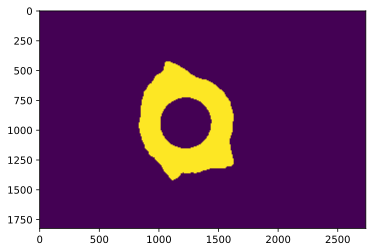

In [8]:
blur_im = ndimage.gaussian_filter(im, 8)
mask = blur_im > blur_im.mean() * 3
plt.imshow(mask)

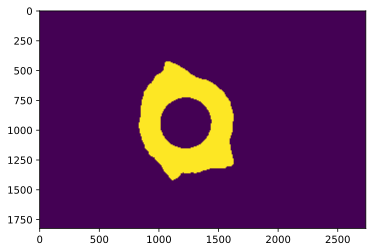

In [9]:
label_im, nb_labels = ndimage.label(mask)
plt.imshow(label_im)

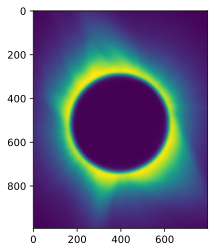

In [10]:
slice_x, slice_y = ndimage.find_objects(label_im==1)[0]
roi = blur_im[slice_x, slice_y]
plt.imshow(roi)

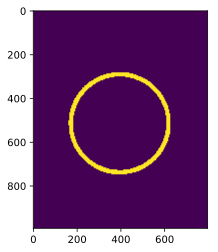

In [11]:
sx = ndimage.sobel(roi, axis=0, mode='constant')
sy = ndimage.sobel(roi, axis=1, mode='constant')
sob = np.hypot(sx, sy)
plt.imshow(sob > (sob.mean() * 5))

In [12]:
from skimage.transform import hough_circle, hough_circle_peaks

hough_radii = np.arange(np.floor(np.mean(sob.shape)/4), np.ceil(np.mean(sob.shape)/2), 10)
hough_res = hough_circle(sob > (sob.mean() * 5), hough_radii)

# Select the most prominent circle
accums, cy, cx, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)
print(cx, cy, radii)

[514] [393] [ 223.]


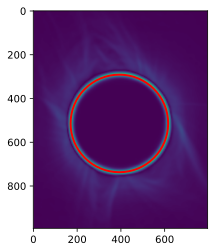

In [13]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
circ = Circle([cy, cx], radius=radii, facecolor='none', edgecolor='red', linewidth=2)
ax.imshow(sob)
ax.add_patch(circ)
plt.show()

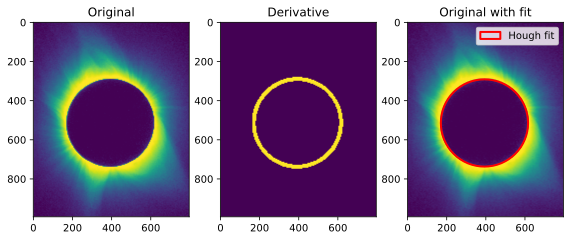

In [14]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(9.5, 6))
ax[0].imshow(im[slice_x, slice_y])
ax[0].set_title('Original')
ax[1].imshow(sob > (sob.mean() * 5))
ax[1].set_title('Derivative')
circ = Circle([cy, cx], radius=radii, facecolor='none', edgecolor='red', linewidth=2, label='Hough fit')
ax[2].imshow(im[slice_x, slice_y])
ax[2].add_patch(circ)
ax[2].set_title('Original with fit')
plt.legend()

Now let's check it with the original image

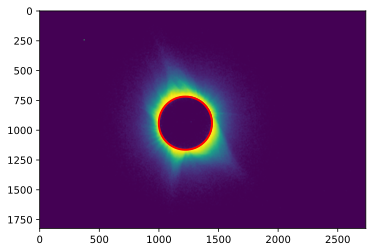

In [15]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
fudge_shift_x = 0 * u.pix # update this in case the fit needs to be shifted in x
fudge_shift_y = 0 * u.pix # update this in case the fit needs to be shifted in y
im_cx = (cx + slice_x.start) * u.pix + fudge_shift_x
im_cy = (cy + slice_y.start) * u.pix + fudge_shift_y
im_radius = radii * u.pix
circ = Circle([im_cy.value, im_cx.value], radius=im_radius.value, facecolor='none', edgecolor='red', linewidth=2)
ax.imshow(im)
ax.add_patch(circ)
plt.show()

In [16]:
masked = im.copy()
masked[slice_x, slice_y] = masked.min()

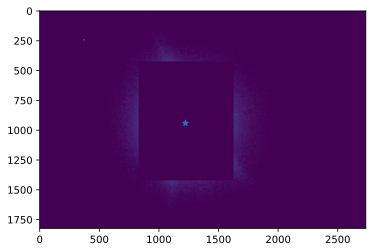

In [17]:
plt.imshow(masked)
plt.plot(im_cy, im_cx, '*')
circ = Circle([im_cy.value, im_cx.value], radius=im_radius.value, facecolor='none', edgecolor='red', linewidth=2)

# Getting information about the Sun

Let's now get the distance between the Earth and the Sun at the time the photo was taken

In [18]:
dsun = sunpy.coordinates.get_sunearth_distance(time.isoformat())
print(dsun)

1.011546589067374 AU


The size of the Sun in the sky is then

In [19]:
rsun_obs = np.arctan(sunpy.sun.constants.radius / dsun).to('arcsec')
print(rsun_obs)

948.0099660006414 arcsec


The image plate scale is then

In [20]:
plate_scale = rsun_obs / im_radius
print(plate_scale)

[ 4.25116577] arcsec / pix


We also need the solar rotation angle

In [21]:
loc = EarthLocation(lat=gps[0], lon=gps[1])
fudge_angle = 0.0 * u.deg # update this in case your camera was not perfectly level.
solar_rotation_angle = sunpy.coordinates.get_sun_orientation(loc, time) + fudge_angle

In [22]:
hgln_obs = 0 * u.deg # sunpy.coordinates.get_sun_L0(time)
hglt_obs = sunpy.coordinates.get_sun_B0(time)
print("{0} {1}".format(hglt_obs, hgln_obs))

6.928156017268407 deg 0.0 deg


# Define your WCS object and header

In [23]:
w = astropy.wcs.WCS(naxis=2)
w.wcs.crpix = [im_cy[0].value, im_cx[0].value]
w.wcs.cdelt = np.ones(2) * plate_scale.to('arcsec/pix').value
w.wcs.crval = [0, 0]
w.wcs.ctype = ['TAN', 'TAN']
w.wcs.cunit = ['arcsec', 'arcsec']
w.wcs.dateobs = time.isoformat()

Using this object we can now create the sunpy map header

In [24]:
header = dict(w.to_header())
header.update({'CROTA2': solar_rotation_angle.to('deg').value})
header.update({'DSUN_OBS': dsun.to('m').value})
header.update({'HGLN_OBS': hgln_obs.to('deg').value})
header.update({'HGLT_OBS': hglt_obs.to('deg').value})
header.update({'CTYPE1': 'HPLN-TAN'})
header.update({'CTYPE2': 'HPLT-TAN'})
header.update({'RSUN': dsun.to('m').value})
header.update({'RSUN_OBS': np.arctan(sunpy.sun.constants.radius / dsun).to('arcsec').value})

Now add metadata about the photograph.

In [25]:
header.update({'AUTHOR': author_str})
header.update({'EXPTIME': exposure_time.to('s').value})
header.update({'TELESCOP': camera_model_str})
header.update({'INSTRUME': camera_model_str})
header.update({'DETECTOR': camera_model_str})

In [26]:
header

{'AUTHOR': 'Steven D. Christe',
 'CDELT1': 4.251165766819,
 'CDELT2': 4.251165766819,
 'CROTA2': -54.32892581530758,
 'CRPIX1': 1222.0,
 'CRPIX2': 941.0,
 'CRVAL1': 0.0,
 'CRVAL2': 0.0,
 'CTYPE1': 'HPLN-TAN',
 'CTYPE2': 'HPLT-TAN',
 'CUNIT1': 'arcsec',
 'CUNIT2': 'arcsec',
 'DATE-OBS': '2017-08-21T17:27:13',
 'DETECTOR': 'Canon EOS 70D',
 'DSUN_OBS': 151325215838.32706,
 'EXPTIME': 0.016666666666666666,
 'HGLN_OBS': 0.0,
 'HGLT_OBS': 6.928156017268407,
 'INSTRUME': 'Canon EOS 70D',
 'LATPOLE': 90.0,
 'RSUN': 151325215838.32706,
 'RSUN_OBS': 948.0099660006414,
 'TELESCOP': 'Canon EOS 70D',
 'WCSAXES': 2}

# Creating SunPy Map

In [27]:
m = sunpy.map.Map((im, header))
m

SunPy Map
---------
Observatory:		 Canon EOS 70D
Instrument:		 Canon EOS 70D
Detector:		 Canon EOS 70D
Measurement:		 0.0
Wavelength:		 0.0
Observation Date:	 2017-08-21 17:27:13
Exposure Time:		 0.016667 s
Dimension:		 [ 2736.  1824.] pix
Coordinate System:	 helioprojective
Scale:			 [ 4.25116577  4.25116577] arcsec / pix
Reference Pixel:	 [ 1222.   941.] pix
Reference Coord:	 [ 0.  0.] arcsec

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

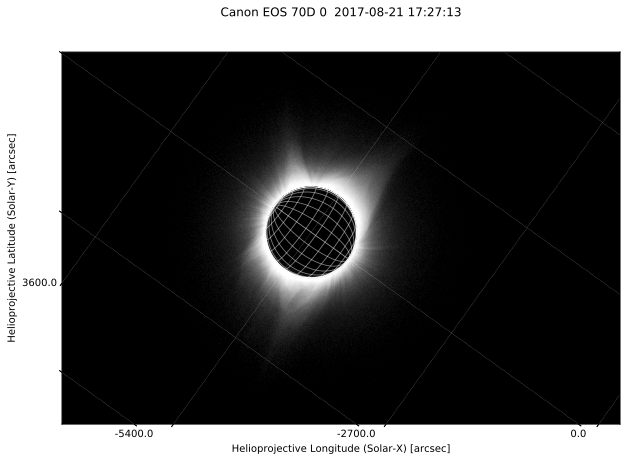

In [28]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=m)
m.plot(axes=ax)
m.draw_grid(axes=ax)
m.draw_limb(axes=ax)
plt.show()

# Overplot the location of Regulus

In [29]:
regulus = SkyCoord(ra='10h08m22.311s', dec='11d58m01.95s',
                   distance=79.3 * u.lightyear, frame='icrs').transform_to(m.coordinate_frame)

In [30]:
regulus

<SkyCoord (Helioprojective: obstime=2017-08-21 17:27:13, rsun=695508000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2017-08-21 17:27:13): (lon, lat, radius) in (deg, deg, m)
    ( 0.,  6.92815602,   1.51325216e+11)>): (Tx, Ty, distance) in (arcsec, arcsec, km)
    (-4478.02801534,  1510.09937509,   7.50236078e+14)>

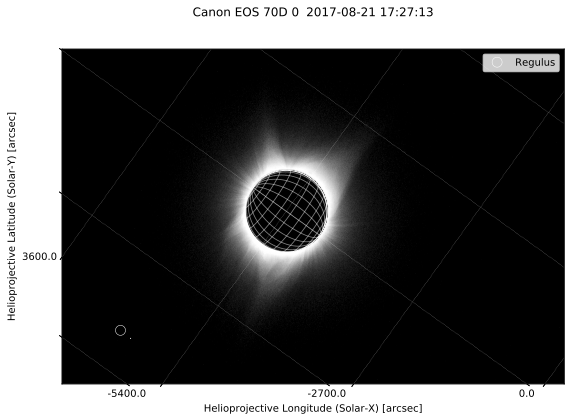

In [31]:
fig = plt.figure(figsize=(9,9))
ax = plt.subplot(projection=m)
m.plot(axes=ax)
ax.plot_coord(regulus, 'o', markeredgewidth=0.5, markeredgecolor='w', 
              markerfacecolor='None', markersize=10, label='Regulus')
m.draw_grid(axes=ax)
m.draw_limb(axes=ax)
plt.legend()
plt.show()

## Using Regulus to calculate image rotation

In this section we are going to use Regulus to work out a correction angle on our image to better align our coordinate system. To do this we will detect the location of Regulus in the image and compare it's actual position with the one calulated by assuming the camera was level with the horizon.

Firstly we calculate the expected pixel location of Regulus in our current coordinate system:

In [32]:
regulus_pixel = m.world_to_pixel(regulus)

Calculate the pixel distance of the expected location from the disk centre.

In [33]:
regulus_r = np.sqrt((regulus_pixel.x - im_cx)**2 + (regulus_pixel.y - im_cy)**2)
regulus_r

<Quantity [ 1119.94228433] pix>

Now calculate an array of pixel distance, that we will use to filter out the disk, for easier detection of Regulus.

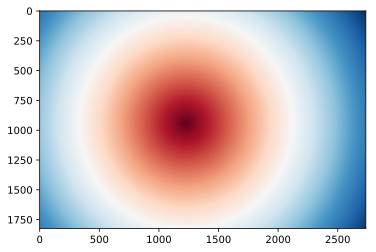

In [34]:
pix_x = np.arange((m.dimensions[0]).value) - im_cy.value
pix_y = np.arange((m.dimensions[1]).value) - im_cx.value
xx, yy = np.meshgrid(pix_x, pix_y)
r = np.sqrt(xx**2 + yy**2)
plt.imshow(r, cmap='RdBu')


We will now filter out the disk by removing everything inside a circle of just under the pixel distance of Regulus.

In [35]:
filter_r = regulus_r - (regulus_r/5)

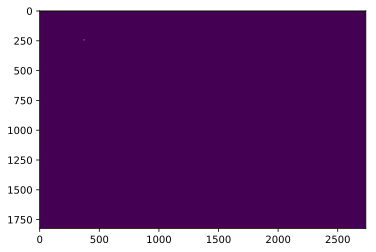

In [36]:
masked = im.copy()
masked[r < filter_r.value] = masked.min()
plt.imshow(masked)

Now we have an image with hopefully only Regulus in it, we can use the star finder rountine from phtoutils to find the pixel coordinates of Regulus in our image. As the image is basically empty we use the half max brightness as our threshold. (We assume that Regulus is the brightest point left).

In [37]:
from photutils import DAOStarFinder
daofind = DAOStarFinder(fwhm=3.0, threshold=masked.max()/2)    
sources = daofind(masked)    
print(sources)  

 id  xcentroid     ycentroid   ...      peak          flux          mag      
--- ------------ ------------- ... ------------- ------------- --------------
  1 371.67556832 247.110905808 ... 222.666666667 2.01287960246 -0.75954449739


In [38]:
regulus_x, regulus_y = sources[0]['xcentroid'] * u.pix, sources[0]['ycentroid'] * u.pix

We can now compare the expected and actual locations of Regulus:

In [39]:
print(regulus_pixel.x, regulus_x)
print(regulus_pixel.y, regulus_y)

318.00754302938117 pix 371.675568319769 pix
291.3275985635323 pix 247.11090580785736 pix


We now use the dot product to calculate the rotation between the expected and actual location of Regulus. Note that the FITS convention angle is opposite in sign to the angle computed in pixel coordinates here.

In [40]:
vec_image = np.array([regulus_x - im_cx, regulus_y - im_cy]).T
vec_coord = np.array([regulus_pixel.x - im_cx, regulus_pixel.y - im_cy])
fudge_angle = np.arccos((vec_image @ vec_coord) / (np.linalg.norm(vec_image) * np.linalg.norm(vec_coord)))*u.rad
fudge_angle = fudge_angle.flat[0] * -1
fudge_angle.to(u.deg)

<Quantity -3.513911909390053 deg>

We now use this angle as our fudge angle to better align the coordinate systems.

In [41]:
solar_rotation_angle = sunpy.coordinates.get_sun_orientation(loc, time) + fudge_angle
print(solar_rotation_angle.to(u.deg).value)
header.update({'CROTA2': solar_rotation_angle.to('deg').value})
m = sunpy.map.Map((im, header))

-57.84283772469763


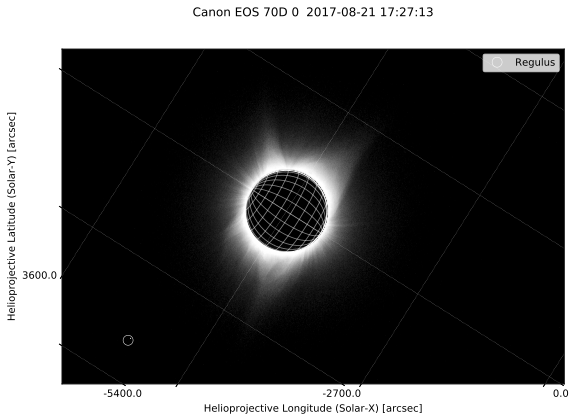

In [42]:
fig = plt.figure(figsize=(9,9))
ax = plt.subplot(projection=m)
m.plot(axes=ax)
ax.plot_coord(regulus, 'o', markeredgewidth=0.5, markeredgecolor='w', 
              markerfacecolor='None', markersize=10, label='Regulus')
m.draw_grid(axes=ax)
m.draw_limb(axes=ax)
plt.legend()
plt.show()

More tweaking could be done here to get thing right. We will leave that as an exercise for the reader!

# Plot an SDO AIA Image of the Sun on your photo

First we need to download the images

In [55]:
from sunpy.net import Fido, attrs as a
# Replace the time below with the time in UT of the eclipse
t = a.Time('2017-08-21 17:27:00', "2017-08-21 17:45:00", '2017-08-21 17:27:13')
aia_result = Fido.search(t, a.Instrument('AIA'), a.Wavelength(171*u.Angstrom))
aia_result

Start Time [1],End Time [1],Source,Instrument,Type,Wavelength [2]
,,,,,Angstrom
str19,str19,str3,str3,str8,float64
2017-08-21 17:27:09,2017-08-21 17:27:10,SDO,AIA,FULLDISK,171.0 .. 171.0


In [44]:
files = Fido.fetch(aia_result[0,0])

[                                        ========================================


In [45]:
files

['/home/stuart/sunpy/data/aia_lev1_171a_2017_08_21t17_27_21_35z_image_lev1.1.fits']

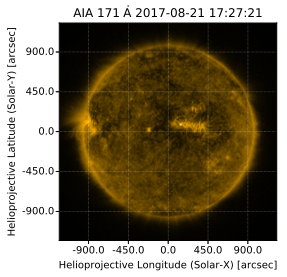

In [46]:
aia_map = sunpy.map.Map(files[0])
aia_map.plot()

To overplot the images we must align them, this can be done with `rotate`.

In [47]:
am2 = aia_map.rotate(rmatrix=np.linalg.inv(m.rotation_matrix),
                     recenter=True, order=3, scale=(aia_map.scale[0]/m.scale[0]))

/home/stuart/Git/sunpy/sunpy/image/transform.py:122: RuntimeWarning: Input data has been cast to float64
  warnings.warn("Input data has been cast to float64", RuntimeWarning)


We then must calculate the extent of the AIA image in terms of pixels in the eclipse image.

In [48]:
xmin, ymin = (u.Quantity(m.reference_pixel) - u.Quantity(am2.reference_pixel)).to_value(u.pix)

In [49]:
xmax = am2.data.shape[1] + xmin
ymax = am2.data.shape[0] + ymin

In [50]:
extent = (xmin, xmax, ymin, ymax)

Finally we mask out the pixels with a low value in the eclipse image (to make the disk transparent).

In [51]:
m2 = copy.deepcopy(m)

In [52]:
m2.data[m.data < 30] = np.nan

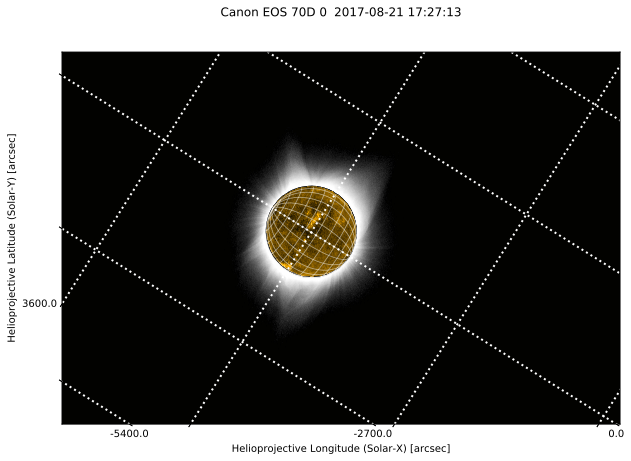

In [53]:
fig = plt.figure(figsize=(10,15))
ax = plt.subplot(projection=m)

# Set the axes background to black.
ax.set_facecolor('k')

# Plot the AIA image.
am2.plot(extent=extent)
# Plot the eclipse image
m2.plot()

# Draw heliographic and helioprojective grids
m2.draw_grid()
ax.coords.grid(color='white', alpha=1, linestyle='dotted',linewidth=2)